In this project, we will be working with Time Series Data and will explore different methods to remove noise from noisy signals. In more detail, we will:

1 - Simulate a pure (noiseless) signal

2 - Add Noise

3 - Try to remove the noise

4 - Compare it with the pure signal

## Smoothing via Running-Mean Filter

The idea of a running mean filter is very straight forward to implement. The formula for it is $y_t = (2k + 1)^{-1} \sum_{i = t-k}^{t+k}x_i$, where x is the original time series data, and we want to define a new filtered signal called y. At each time point we sum the points according to some value k. 

We will first define a pure, noiseless signal defined by $s = \sum_{j=1}^3 cos(jt)^j + r$ where $t \in (0,4\pi)$ and $r \sim N(0,1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.signal import detrend
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

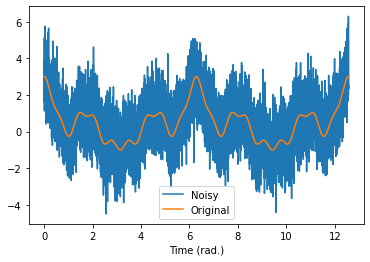

In [2]:
N = 10001
time = np.linspace(0, np.pi*4, N)
signal = np.zeros(N)

for j in range(1,4):
    signal += np.cos(j*time)**j

noisysignal = signal + np.random.randn(N)
plt.plot(time, noisysignal, time, signal)
plt.xlabel("Time (rad.)")
plt.legend(["Noisy", "Original"])
plt.show()

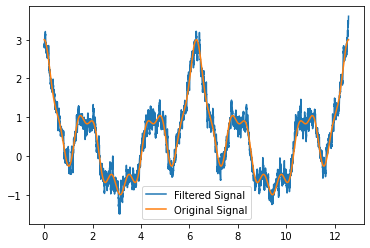

In [3]:
# Running Mean Filter (Mean-Smoothing Filter)
filtsignal = copy.deepcopy(noisysignal)
k = 15

for i in range(N):
    lowbnd = np.max((0,i-k))
    uppbnd = np.min((N,i+k))
    filtsignal[i] = np.mean(noisysignal[lowbnd:uppbnd])

plt.plot(time, filtsignal, time, signal)
plt.legend(["Filtered Signal", "Original Signal"])
plt.show()

In [4]:
print(np.max((0,i-k)))
print(np.min((N,i+k)))

9985
10001


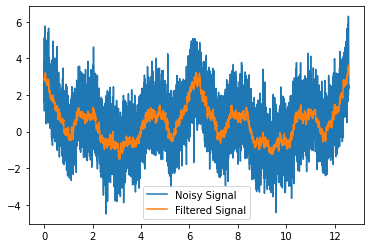

In [5]:
plt.plot(time, noisysignal, time, filtsignal)
plt.legend(["Noisy Signal", "Filtered Signal"])
plt.show()

In [6]:
# Find better smoothing values of k
def meansmooth(signalIn, k):
    filtsignal = copy.deepcopy(signalIn)
    for i in range(N):
        filtsignal[i] = np.mean(noisysignal[np.max((0,i-k)):np.min((N,i+k))])
    return filtsignal

In [7]:
# Create a plot showing correlation between filtered and noiseless signal
kvals = np.arange(5,41)
signalCorrs = []
for ki in kvals:
    # filter the signal
    fsig = meansmooth(noisysignal, ki)
    # compute correlation btw signal and original noiseless signal
    signalCorrs.append(np.corrcoef(fsig, signal)[0,1])
signalCorrs[0:10]

[0.9482682236366279,
 0.9565798416625924,
 0.9625750764105517,
 0.967169430918508,
 0.9706479158184106,
 0.9735638697405351,
 0.976004032720181,
 0.9780545308426865,
 0.9798565105726562,
 0.9814404667169657]

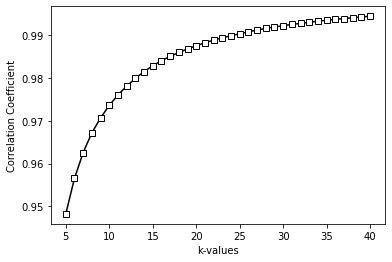

In [8]:
plt.plot(kvals, signalCorrs, "ks-", markerfacecolor = "w")
plt.xlabel("k-values")
plt.ylabel("Correlation Coefficient")
plt.show()

## Smoothing Via Gaussian Convolution

This is a sifferent method for smoothing time-series data, conceptually similar to mean-smoothing but with different implementation. First ,we will generate a signal and add noise, and then we will denoise it.

$s = detrend(t^3 + sgn(t)) + r$

$t \in (-2, 2)(seconds)$

$r \sim N(0,1.1^2$

$fs = 512 Hz$

$g = \exp(\frac{-x^2}{2\sigma^2}) $

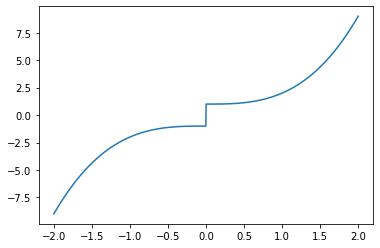

In [9]:
# create the signal
srate = 512
time = np.arange(-2,2 + 1/srate,1/srate)
pnts = len(time)

signal = time**3 + np.sign(time)
plt.plot(time, signal);

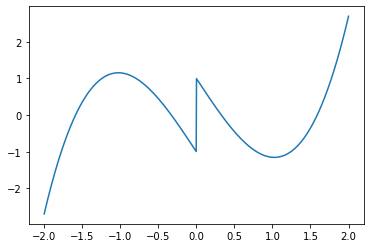

In [10]:
# Let's Detrend the signal
signal = detrend(signal)
plt.plot(time,signal);

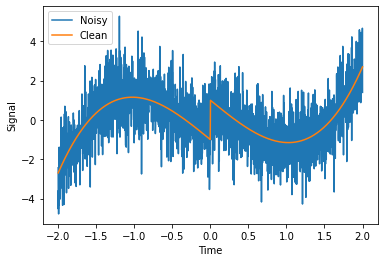

In [11]:
# Add noise to the signal
noisysignal = signal + np.random.randn(pnts)*1.1 # variance = (1.1)^2
plt.plot(time, noisysignal, time, signal)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend(["Noisy", "Clean"])
plt.show()

In [12]:
# Create the Gaussian
k = 10
x = np.arange(-k, k+1)/srate
x

array([-0.01953125, -0.01757812, -0.015625  , -0.01367188, -0.01171875,
       -0.00976562, -0.0078125 , -0.00585938, -0.00390625, -0.00195312,
        0.        ,  0.00195312,  0.00390625,  0.00585938,  0.0078125 ,
        0.00976562,  0.01171875,  0.01367188,  0.015625  ,  0.01757812,
        0.01953125])

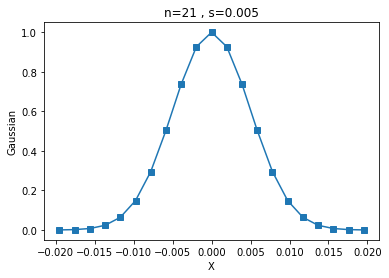

In [13]:
s = 0.005 # sigma
gkern = np.exp(-x**2/(2*s**2))
plt.plot(x, gkern, "s-")
plt.title("n=%s , s=%g"%(2*k+1, s))
plt.xlabel("X")
plt.ylabel("Gaussian")
plt.show()

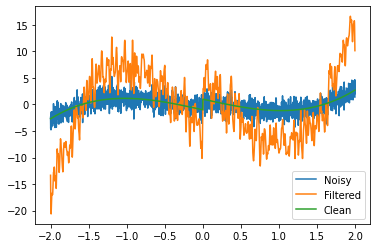

In [14]:
# Guassian is a weighted smoothing: The points at the center of the
# kernel get the highest weights, while at the margins it becomes smaller
# as shown in the bell curve above
filtsig = np.convolve(noisysignal, gkern, mode="same")
plt.plot(time, noisysignal, time, filtsig, time, signal)
plt.legend(["Noisy", "Filtered", "Clean"])
plt.show()

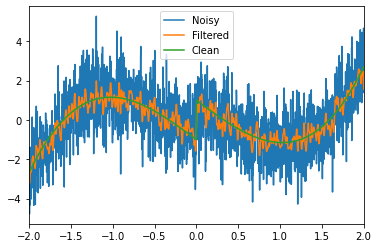

In [15]:
# Unit normalize Gaussian Kernel
gkern /= sum(gkern)
filtsig = np.convolve(noisysignal, gkern, mode="same")
plt.plot(time, noisysignal, time, filtsig, time, signal)
plt.legend(["Noisy", "Filtered", "Clean"])
plt.xlim(time[[0,-1]])
plt.show()

In [16]:
# Define parameter ranges for the Gaussian: length and sigma
krange = np.arange(3,304, 20)
srange = np.linspace(0.001, 0.5, 60) # it cant be zero: denominator
srate = 512

# Initialize some output variables
sseMat = np.zeros( (len(krange), len(srange)) )

# Initialize a double list to store gaussians
# This is a matrix of lists
allkernels = [[0]*len(srange) for i in range(len(krange))]

# Double-Loop over two parameters
for ki in range(len(krange)):
    for si in range(len(srange)):
        
        # create Gaussian
        x = np.arange(-krange[ki], krange[ki]+1)/srate
        gkern = np.exp(-x**2/(2*srange[si]**2))
        
        # Filter signal
        filtsig = np.convolve(noisysignal, gkern/sum(gkern), mode ="same")
        
        # Compute SSE
        sseMat[ki, si] = np.sum((filtsig - signal)**2)
        
        allkernels[ki][si] = gkern

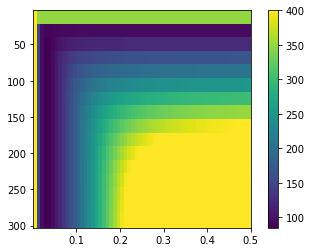

In [17]:
plt.imshow(sseMat, vmax = 400,
           extent = [srange[0], srange[-1], krange[-1], krange[0]])
plt.gca().set_aspect(1/plt.gca().get_data_ratio())
plt.colorbar()
plt.show()

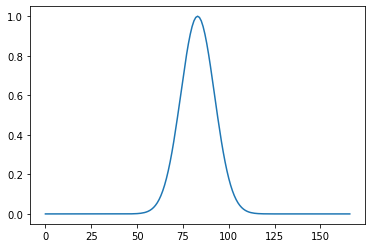

In [18]:
plt.plot(allkernels[4][2]);

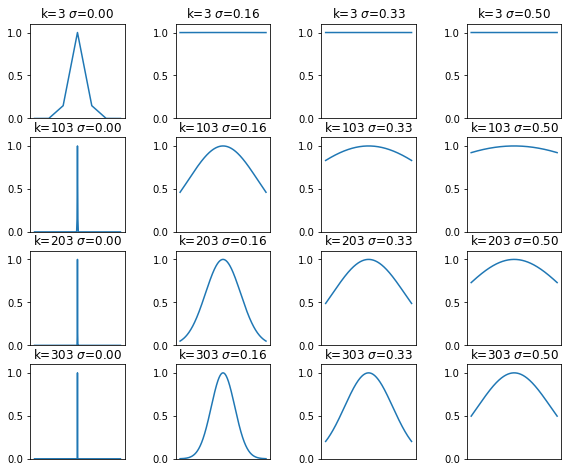

In [19]:
# Plot a few randomly-selected Gaussian Kernels
fig, ax = plt.subplots(4,4, figsize = (10,8))

# 4 Equally-spaced points on the grid
sidx = np.linspace(0, len(srange)-1, 4).astype(int)
kidx = np.linspace(0, len(krange)-1, 4).astype(int)

for si in range(4):
    for kj in range(4):
        ax[kj,si].plot(allkernels[kidx[kj]][sidx[si]])
        ax[kj,si].set_xticks([])
        ax[kj,si].set_ylim([0,1.1])
        ax[kj,si].set_title("k=%g $\sigma$=%.2f"%(krange[kidx[kj]],srange[sidx[si]]))
        ax[kj,si].set_aspect(1/ax[kj,si].get_data_ratio())
plt.show()

## Despeckling Via Median Filter

This is a non-linear filter. The signal we are going to create is as follows:

$s = t^2mod5 +n$

$n = (U(0,1) < 0.1) x (U(10, 110))$

$t \in (0,5)$

We will select data points larger than a certain threshold and replace them by the median of the surrounding data. For a certain parameter k, the data point exceeding the threshold will be replaced by the median of adjacent point - k and adjacent point plus k.

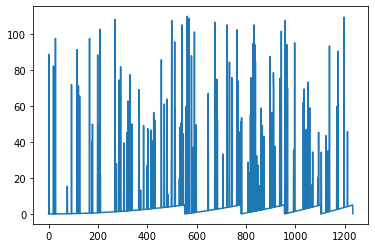

In [20]:
pnts = 1234
signal = np.mod(np.linspace(0,5,pnts)**2,5)

# Noise
p = int(0.1*pnts)
spiketimes = np.random.randint(0,pnts,p)
signal[spiketimes] = np.random.rand(p)*100 + 10

plt.plot(signal)
plt.show()

In [21]:
p = int(0.1*pnts)
p

123

In [22]:
spiketimes

array([ 647,  337,  540,  385, 1105,  498,  591,  912,  780, 1138,  176,
        269,  848,  768,  546,  373, 1052,  275,  121,  911,  968,  178,
        959,  965,  743,  843, 1168,  815,  773, 1211,  808, 1036,  536,
        763, 1058,  562,  937,  838,   76,  569, 1124,  480,   28,  818,
        424,  199,  733, 1070,  682,  707,  402,  912,  674, 1067,  853,
        317,  901,    2,  373, 1044,  872,  820,  210,   20,  499,  366,
        292,  586,  469,   93,  905,  208,  203,  329,  866,  724,  829,
        565,  166,  513,  943,  898,  579,  126,  861, 1197,  873, 1132,
        426,  684,  457,  400, 1032,  305,  598,  872, 1094,  511,  941,
        484,  533,  322,  530,  116,  993,  513,  821,  289,  771,  557,
        997,  782,  918,  833,  917, 1172,  416,  338,  431, 1035, 1091,
        285,  836])

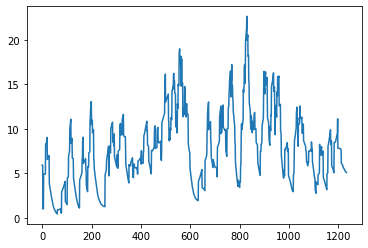

In [23]:
# Try mean-filtering: NOT GOOD
k = 15
signal2 = copy.deepcopy(signal)
for i in range(pnts):
    signal2[i] = np.mean(signal2[np.max((0,i-k)):np.min((pnts, i+k))])
plt.plot(signal2);

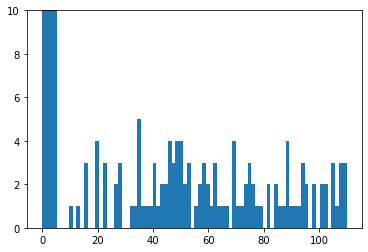

In [24]:
# Empirically define a threshold for spikes

plt.hist(signal,80)
plt.ylim([0,10])
plt.show()
# Pick a threshold of 8

In [25]:
thresh = 8

# Find all supra-threshold data indices
# signal > thresh

suprathresholdidx = np.where(signal > thresh)[0]

len(suprathresholdidx)/pnts*100

9.643435980551054

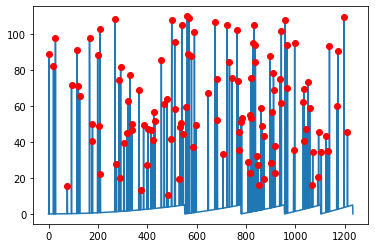

In [26]:
plt.plot(signal)
plt.plot(suprathresholdidx, signal[suprathresholdidx], "ro")
plt.show()

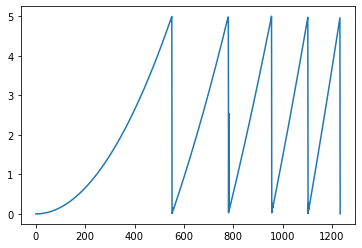

In [27]:
k = 7
for i in suprathresholdidx:
    lowbnd = np.max((0, i-k))
    uppbnd = np.min((pnts, i+k))
    signal[i] = np.median(signal[lowbnd:uppbnd])
plt.plot(signal)
plt.show()

## Denoise Biomedical Data

This time we will use real data from EKG readings from hearts

In [28]:
df = pd.read_csv("EKG_signals.csv", sep = ",", names = ["noisy", "orig"])
df.head()

,noisy,orig
0,920.23,963
1,929.06,987
2,1116.60,1024
3,1073.60,1073
4,1070.60,1134


In [29]:
df.shape

(1000, 2)

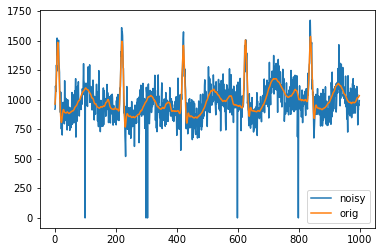

In [30]:
# Simple way to plot
df.plot()
plt.show()

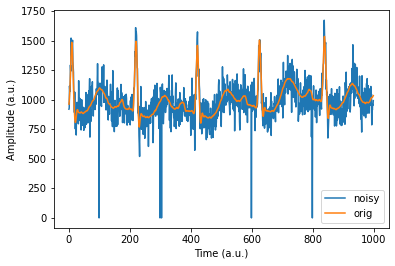

In [31]:
# One-by-one way
plt.plot(df["noisy"], label = "noisy")
plt.plot(df["orig"], label = "orig")
plt.legend()
plt.ylabel("Amplitude (a.u.)")
plt.xlabel("Time (a.u.)")
plt.show()

In [32]:
# We will first use median filter to get rid of the lower spikes, 
# then a mean filter to get rid of the normally-distributed noise
# Let's Denoise it using a median filter
df["filtered"] = df["noisy"].copy()
df.head()

,noisy,orig,filtered
0,920.23,963,920.23
1,929.06,987,929.06
2,1116.60,1024,1116.60
3,1073.60,1073,1073.60
4,1070.60,1134,1070.60


In [33]:
# Median filter for small values
# Pick a threshold of above 300
threshold = 321

# Find subthreshold data indices
subthreshidx = np.where(df["filtered"] < threshold)[0]
subthreshidx

array([ 99, 299, 304, 599, 799])

<AxesSubplot:>

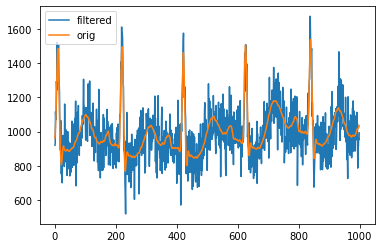

In [34]:
# Apply the median filter
k = 7
for i in subthreshidx:
    df["filtered"][i] = np.median(df["filtered"][np.max((0,i-k)):np.min((len(df),i+k))])
    
df[["filtered", "orig"]].plot()

In [35]:
# Check Row 99 how it was changed
df[95:102]

,noisy,orig,filtered
95,1161.80,1077,1161.80
96,1144.30,1080,1144.30
97,1085.50,1085,1085.50
98,1103.00,1090,1103.00
99,0.00,1095,1094.25
100,1043.70,1099,1043.70
101,950.74,1100,950.74


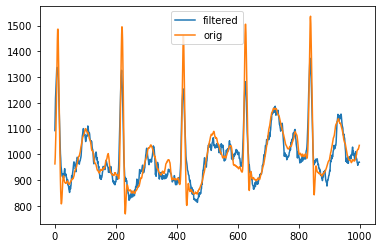

In [36]:
# Apply Mean Filter
k = 7

for i in range(len(df)):
    df["filtered"][i] = np.mean(df["filtered"][np.max((0,i-k)):np.min((len(df),i+k))])

df[["filtered", "orig"]].plot();

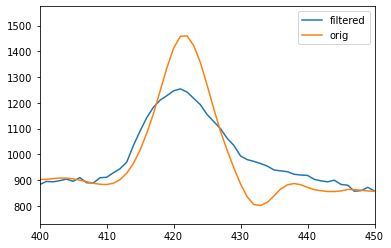

In [37]:
df[["filtered", "orig"]].plot()
plt.xlim([400, 450])
plt.show()

## Patches Highlighting Plot Data

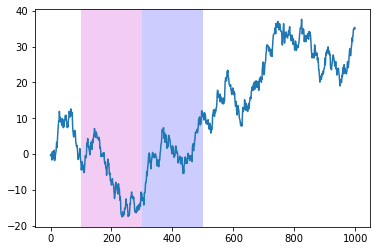

In [38]:
# Create a Brownian Time Series
x = np.cumsum(np.random.randn(1000))

fig,ax = plt.subplots(1)
ax.plot(x)
ylim = ax.get_ylim()
ax.fill_between([100,300],ylim[0],ylim[1], 
               facecolor = "m", alpha = 0.2)
ax.fill_between([301,500],ylim[0],ylim[1], 
               facecolor = "b", alpha = 0.2)

ax.set_ylim(ylim) # set the y-lim to cover everything
plt.show()

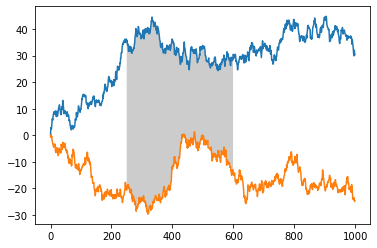

In [39]:
x1 = np.cumsum(np.random.randn(1000))
x2 = np.cumsum(np.random.randn(1000))

fig,ax = plt.subplots(1)
ax.plot(x1)
ax.plot(x2)

xlim = np.arange(250,600)
ax.fill_between(xlim, x1[xlim], x2[xlim], facecolor = "k", alpha = 0.2)
plt.show()